# Training GANs - Generative Adversarial Networks

Using the architecture created by Teal Witter for demo 11 with some modifications.

## Libaries

As always, we load lots of libraries.

In [ ]:
import torch
from torchvision import datasets
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms
import numpy as np
import os
from matplotlib.pyplot import imsave
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from torchvision.models import inception_v3
from scipy.linalg import sqrtm
from PIL import Image
import torch.nn.functional as F
from torchvision.models import inception_v3
from torchvision.transforms import Resize
from torch.nn.functional import softmax


## Data

In [ ]:
# A transform to convert the images to tensor and normalize their RGB values
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(mean=[0.5], std=[0.5])]
)

data = datasets.FashionMNIST(root='../data/', train=True, transform=transform, download=True)

batch_size = 64
data_loader = DataLoader(dataset=data, batch_size=batch_size, shuffle=True, drop_last=True)

100%|██████████| 26421880/26421880 [00:00<00:00, 114901074.52it/s]


Extracting ../data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 5206497.14it/s]

Extracting ../data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw




100%|██████████| 4422102/4422102 [00:00<00:00, 65987050.33it/s]


Extracting ../data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 4401197.92it/s]

Extracting ../data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



In [ ]:
def get_sample_image(G, DEVICE, n_noise=100):
   img = np.zeros([280, 280])
   for j in range(10):
       z = torch.randn(10, n_noise).to(DEVICE)
       y_hat = G(z).view(10, 28, 28)
       result = y_hat.cpu().data.numpy()
       img[j*28:(j+1)*28] = np.concatenate([x for x in result], axis=-1)
   return img


## Architecture


In [ ]:
class Generator(nn.Module):
    def __init__(self, input_size=100, image_size=28*28):
        super(Generator, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, image_size),
            nn.Tanh()
        )

    def forward(self, x):
      x = x.view(x.size(0), -1)
      y_ = self.network(x)
      return y_


In [ ]:
class Discriminator(nn.Module):
    def __init__(self, input_size=28*28, num_output=1):
        super(Discriminator, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, num_output),
            nn.Sigmoid(),
        )
    def forward(self, x):
      x = x.view(x.size(0), -1)
      y_ = self.network(x)
      return y_


## Set up and Training


In [ ]:
images,class_labels = next(iter(data_loader))

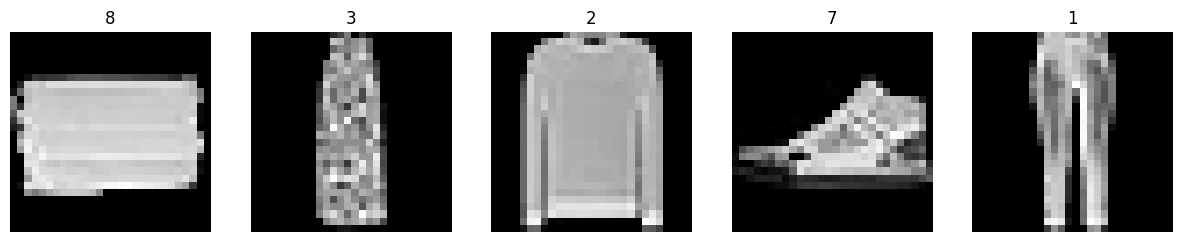

In [ ]:
fig, axs = plt.subplots(1, 5, figsize=(15, 3))
for i in range(5):
   axs[i].imshow(images[i].squeeze().numpy(), cmap='gray')
   axs[i].set_title(class_labels[i].item())
   axs[i].axis('off')

plt.show()

In [ ]:
MODEL_NAME = 'GAN'
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

D = Discriminator().to(DEVICE) # randomly intialized
G = Generator().to(DEVICE) # randomly initialized

max_epoch = 10
step = 0
n_noise = 100 # size of noise vector

criterion = nn.BCELoss()
D_opt = torch.optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))
G_opt = torch.optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))

# We will denote real images as 1s and fake images as 0s
# This is why we needed to drop the last batch of the data loader
all_ones = torch.ones([batch_size, 1]).to(DEVICE) # Discriminator label: real
all_zeros = torch.zeros([batch_size, 1]).to(DEVICE) # Discriminator Label: fake

In [ ]:
# a directory to save the generated images
if not os.path.exists('samples'):
    os.makedirs('samples')

for epoch in range(max_epoch):
    for idx, (images,class_labels) in enumerate(data_loader):
        # Training Discriminator
        x = images.to(DEVICE)
        x_outputs = D(x)
        D_x_loss = criterion(x_outputs, all_ones) # Discriminator loss for real images

        z = torch.randn(batch_size, n_noise).to(DEVICE)
        z_outputs = D(G(z)) # input to both generator and discriminator
        D_z_loss = criterion(z_outputs, all_zeros) # Discriminator loss for fake images
        D_loss = D_x_loss + D_z_loss # Total Discriminator loss

        D.zero_grad()
        D_loss.backward()
        D_opt.step()

        # Training Generator
        z = torch.randn(batch_size, n_noise).to(DEVICE)
        z_outputs = D(G(z)) # input to both generator and discriminator
        G_loss = -1 * criterion(z_outputs, all_zeros) # Generator loss is negative disciminator loss

        G.zero_grad()
        G_loss.backward()
        G_opt.step()

        if step % 500 == 0:
            print('Epoch: {}/{}, Step: {}, D Loss: {}, G Loss: {}'.format(epoch, max_epoch, step, D_loss.item(), G_loss.item()))

        if step % 1000 == 0:
            G.eval()
            img = get_sample_image(G, DEVICE, n_noise)
            imsave('samples/{}_step{}.jpg'.format(MODEL_NAME, str(step).zfill(3)), img, cmap='gray')
            G.train()
        step += 1

Epoch: 0/10, Step: 0, D Loss: 1.374230980873108, G Loss: -0.7049151062965393
Epoch: 0/10, Step: 500, D Loss: 1.1564217805862427, G Loss: -0.3793366849422455
Epoch: 1/10, Step: 1000, D Loss: 1.2312697172164917, G Loss: -0.3801102042198181
Epoch: 1/10, Step: 1500, D Loss: 1.3223042488098145, G Loss: -0.492179274559021
Epoch: 2/10, Step: 2000, D Loss: 1.2864410877227783, G Loss: -0.686050534248352
Epoch: 2/10, Step: 2500, D Loss: 1.2568433284759521, G Loss: -0.4896122217178345
Epoch: 3/10, Step: 3000, D Loss: 1.2039647102355957, G Loss: -0.5586730241775513
Epoch: 3/10, Step: 3500, D Loss: 1.2168699502944946, G Loss: -0.48184606432914734
Epoch: 4/10, Step: 4000, D Loss: 1.2266099452972412, G Loss: -0.554595947265625
Epoch: 4/10, Step: 4500, D Loss: 1.2374005317687988, G Loss: -0.6156617999076843
Epoch: 5/10, Step: 5000, D Loss: 1.3801589012145996, G Loss: -0.5221776366233826
Epoch: 5/10, Step: 5500, D Loss: 1.3211414813995361, G Loss: -0.5733713507652283
Epoch: 6/10, Step: 6000, D Loss: 1.

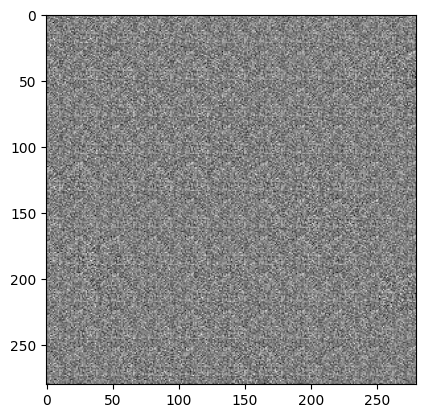

In [ ]:
img = mpimg.imread('samples/GAN_step000.jpg')
imgplot = plt.imshow(img)
plt.show()

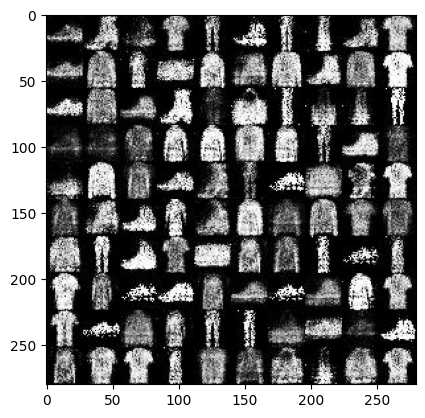

In [ ]:
img = mpimg.imread('samples/GAN_step5000.jpg')
imgplot = plt.imshow(img)
plt.show()

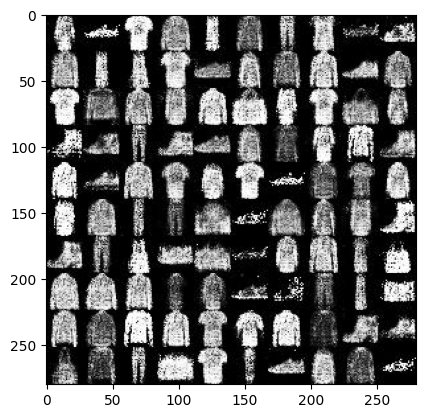

In [ ]:
img = mpimg.imread('samples/GAN_step9000.jpg')
imgplot = plt.imshow(img)
plt.show()

# Measures of GAN Quality

Inception Score (IS): This measure uses a pre-trained deep learning neural network model for image classification to classify the generated images. Specifically, the Inception v3 model is used. The Inception score is widely adopted score for GAN evaluation.

In [ ]:
def calculate_inception_score(G, DEVICE, n_noise=100, num_samples=5000, batch_size=50):
    model = inception_v3(pretrained=True, transform_input=False).to('cpu').eval()

    # Move the generator to the same device as the Inception model
    G = G.to(DEVICE)

    # Resize transform
    resize_transform = Resize((299, 299))

    # Generate samples
    all_samples = []
    with torch.no_grad():
        for _ in range(num_samples // batch_size):
            noise = torch.randn(batch_size, n_noise).to(DEVICE)
            generated_images = G(noise).view(batch_size, 1, 28, 28)

            # Duplicate the single channel to three channels
            generated_images = generated_images.expand(-1, 3, -1, -1)

            # Resize images to meet the minimum size requirement of Inception model
            generated_images = resize_transform(generated_images)

            all_samples.append(generated_images.cpu())

    # Concatenate samples in smaller batches to reduce memory usage
    all_samples = torch.cat(all_samples, dim=0)

    # Compute Inception Score
    preds = softmax(model(all_samples), dim=1)
    scores = []
    for i in range(preds.shape[0] // 10):
        split_scores = preds[i * 10: (i + 1) * 10]
        kl = split_scores * (torch.log(split_scores) - torch.log(torch.mean(split_scores, dim=0)))
        kl = kl.sum(dim=1)
        scores.append(torch.exp(kl.mean()))
    inception_score = torch.mean(torch.tensor(scores))

    return inception_score.item()


trained_inception_score = calculate_inception_score(G, DEVICE, num_samples=500, batch_size=10)
print(f'Inception Score: {trained_inception_score}')


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:00<00:00, 182MB/s] 
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing tr

Inception Score: 2.328282117843628


Fréchet Inception Distance (FID): This metric compares the distributions of Inception embeddings (activations from the penultimate layer of the Inception network) of real and generated images. Both these distributions are modeled as multi-dimensional Gaussians parameterized by their respective mean and covariance \\
Fréchet ResNet Distance (FRD): Similar to FID, it measures the distance between the real and generated image distributions using features extracted from a ResNet.

The images generated in the demo based on the MNSIT dataset more closely resemble the original images. The images being generated on the FashionMNSIT dataset still has a bit of noise and isnt very similar to the original dataset images.

In [ ]:
import torch
torch.cuda.empty_cache()